In [1]:
import numpy as np
from numpy import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical
import pandas as pd

In [1]:
path='C:\\Users\dmckenzie\Desktop\K12RoomTypeClassData2.csv'
DATIS=pd.read_csv(path)
DATIS=DATIS.drop(columns='Unnamed: 0')
import re
def preprocessor(text): 
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

DATIS['CleanName']=DATIS['RoomName'].str.replace('/',' ').replace({' +':' '},regex=True).apply(preprocessor)
DATIS['NameLen']=DATIS['RoomName'].str.len()
DATIS['RoomName']=DATIS['RoomName'].str.lower()
DATIS['TokenCount']=((DATIS['RoomName'].str.len()-DATIS['RoomName'].str.replace(' ','').str.len())+1)
DATIS.Label2=DATIS.Label2.str.lower()
DATIS['RoomType']=np.where(DATIS['RoomName'].str.lower().str.contains('corridor'),'corridor',
         np.where(DATIS['RoomName'].str.lower().str.contains('shower'),'shower',
         np.where(DATIS['RoomName'].str.contains('|'.join([' rr','restroom','bathroom','lavartory',
                                                        'washroom','wash room','wash_room',
                                                        'tlt','toielt','bath room','rest room',
                                                        'bath_room','rest_room'])),'bathroom',
           np.where(DATIS['Label2']=='small group','other',        
          np.where(DATIS['Label2']=='special english','other',DATIS['Label2'])))))

binomiallist=[]
for i in range(0,len(DATIS)):
        binomiallist.append(np.random.binomial(1, .025))

DATIS['Keep']=binomiallist
DATIS['Keep']=np.where(DATIS['RoomType']=='other',DATIS['Keep'],1)
DATIS2=DATIS[DATIS['Keep']==1]
DATIS2=DATIS2.drop_duplicates(['RoomType','CleanName'])
y = DATIS2.RoomType.str.lower()
DATIS2['Name'] = DATIS2['CleanName']
X = DATIS2['Name']
        

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

In [3]:
len(y_train.drop_duplicates())

23

In [4]:
train_size = int(len(X_train))
train_posts = X_train
train_tags = y_train

test_posts = X_test
test_tags = y_test

max_words = 20
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = 23
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
classes=list(pd.DataFrame({"q":train_tags,"b":y_train.argmax(axis=-1)}).drop_duplicates(subset=['q','b']).sort_values('b')['q'])

In [6]:
from tensorflow.keras import layers
adapt_data = list(X_train)
# Create a TextVectorization layer
text_vectorizer = layers.TextVectorization(output_mode="int",output_sequence_length=6)
# Index the vocabulary via `adapt()`
text_vectorizer.adapt(adapt_data)

In [7]:
vectorized=text_vectorizer(list(X_train))

In [8]:
vectorized2=text_vectorizer(list(X_test))

In [9]:
text_vectorizer(list(X_test))

<tf.Tensor: shape=(478, 6), dtype=int64, numpy=
array([[  1,  86,   3,   0,   0,   0],
       [ 14,  29,  36,  47,   0,   0],
       [ 14,  13,   0,   0,   0,   0],
       ...,
       [  1,  55,   0,   0,   0,   0],
       [448,   0,   0,   0,   0,   0],
       [  1, 428,   4,   0,   0,   0]], dtype=int64)>

In [10]:
text_vectorizer(list(['gym class class class class class class class class']))

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[ 13, 206, 206, 206, 206, 206]], dtype=int64)>

In [11]:
vocab=text_vectorizer.get_vocabulary()

In [12]:
pd.DataFrame({'Vocab':pd.Series(vocab)}).to_csv('Vocab.csv',index=False)

In [13]:
pd.DataFrame({'Classes':pd.Series(classes)}).to_csv('Classes.csv',index=False)

In [14]:
classes

['a.v.',
 'art exist',
 'bathroom',
 'classroom',
 'conference large',
 'corridor',
 'custodial',
 'electrical',
 'gym',
 'kitchen district',
 'lab',
 'library sto',
 'lobby vest',
 'locker shower',
 'lounge leadership',
 'mechanical',
 'music vocal',
 'office specialist',
 'other',
 'principal vice',
 'science',
 'shower',
 'storage']

In [15]:
#text_vectorizer.get_vocabulary()[29]

In [16]:
batch_size = 100
epochs = 250

# Build the model
model = Sequential()
model.add(layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), output_dim=(200)))
#model.add(layers.SimpleRNN(200,return_sequences=True))
#model.add(layers.SimpleRNN(500,return_sequences=True))
#model.add(layers.Dropout(.3))
#model.add(layers.SimpleRNN(400,return_sequences=True))
#model.add(layers.Dropout(.3))
#model.add(layers.SimpleRNN(200))
#model.add(layers.Dropout(.3))
model.add(layers.GRU(50))
model.add(layers.Dense(23,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(vectorized, tf.constant(y_train),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/250
7/7 [==============================] - 1s 50ms/step - loss: 3.1034 - accuracy: 0.0963 - val_loss: 3.0437 - val_accuracy: 0.1250
Epoch 2/250
7/7 [==============================] - 0s 7ms/step - loss: 3.0043 - accuracy: 0.1118 - val_loss: 2.9302 - val_accuracy: 0.1250
Epoch 3/250
7/7 [==============================] - 0s 6ms/step - loss: 2.8847 - accuracy: 0.1118 - val_loss: 2.7937 - val_accuracy: 0.1250
Epoch 4/250
7/7 [==============================] - 0s 6ms/step - loss: 2.7610 - accuracy: 0.1118 - val_loss: 2.6874 - val_accuracy: 0.1389
Epoch 5/250
7/7 [==============================] - 0s 6ms/step - loss: 2.7038 - accuracy: 0.1972 - val_loss: 2.6147 - val_accuracy: 0.1806
Epoch 6/250
7/7 [==============================] - 0s 6ms/step - loss: 2.6604 - accuracy: 0.1755 - val_loss: 2.5589 - val_accuracy: 0.1806
Epoch 7/250
7/7 [==============================] - 0s 6ms/step - loss: 2.6068 - accuracy: 0.1770 - val_loss: 2.5105 - val_accuracy: 0.1806
Epoch 8/250
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.6563 - val_accuracy: 0.9167
Epoch 118/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.6569 - val_accuracy: 0.9167
Epoch 119/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.6572 - val_accuracy: 0.9167
Epoch 120/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.6574 - val_accuracy: 0.9167
Epoch 121/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.6578 - val_accuracy: 0.9167
Epoch 122/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.6582 - val_accuracy: 0.9167
Epoch 123/250
7/7 [==============================] - 0s 7ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.6583 - val_accuracy: 0.9167
Epoch 124/250
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7040 - val_accuracy: 0.9028
Epoch 234/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7043 - val_accuracy: 0.9028
Epoch 235/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7047 - val_accuracy: 0.9028
Epoch 236/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7051 - val_accuracy: 0.9028
Epoch 237/250
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7055 - val_accuracy: 0.9028
Epoch 238/250
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7058 - val_accuracy: 0.9028
Epoch 239/250
7/7 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7062 - val_accuracy: 0.9028
Epoch 240/250
7/7 [========

In [17]:
from onnxmltools import save_model
from onnxruntime import InferenceSession
import tf2onnx
onnx_model, _ = tf2onnx.convert.from_keras(model,  opset=13)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [18]:
save_model(onnx_model, 'RoomClassKeras.onnx')
sess = InferenceSession("RoomClassKeras.onnx")

In [19]:
label_name = sess.get_outputs()[0].name
input_name = sess.get_inputs()[0].name
print(label_name)
print(input_name)

dense
embedding_input


In [20]:
string=text_vectorizer(list(['gym classroom'])).numpy().tolist()[0]
res = sess.run(None, input_feed={'embedding_input': ([string])})
classes[np.argmax(res)]

'gym'

In [22]:
string=text_vectorizer(list(['classroom gym'])).numpy().tolist()[0]
res = sess.run(None, input_feed={'embedding_input': ([string])})
classes[np.argmax(res)]

'gym'

In [23]:
string=text_vectorizer(list(['workout room'])).numpy().tolist()[0]
res = sess.run(None, input_feed={'embedding_input': ([string])})
res
#classes[np.argmax(res)]

[array([[8.82225431e-05, 8.14294268e-04, 2.93858303e-03, 1.53879065e-03,
         3.86792730e-04, 6.23828018e-05, 1.06277093e-05, 1.34795834e-03,
         1.05181355e-02, 1.85645622e-05, 3.69014160e-05, 9.74707218e-05,
         4.61232336e-03, 5.26635170e-01, 4.95208893e-03, 1.96480332e-03,
         1.30378001e-04, 2.99044937e-01, 8.21723714e-02, 2.88232835e-03,
         5.78855388e-02, 3.44390166e-04, 1.51694857e-03]], dtype=float32)]

In [24]:
np.argmax(res)

13

In [25]:
classes

['a.v.',
 'art exist',
 'bathroom',
 'classroom',
 'conference large',
 'corridor',
 'custodial',
 'electrical',
 'gym',
 'kitchen district',
 'lab',
 'library sto',
 'lobby vest',
 'locker shower',
 'lounge leadership',
 'mechanical',
 'music vocal',
 'office specialist',
 'other',
 'principal vice',
 'science',
 'shower',
 'storage']

In [27]:
string=text_vectorizer(list(['gym'])).numpy().tolist()[0]
res = sess.run(None, input_feed={'embedding_input': ([string])})
classes[np.argmax(res)]

'gym'

In [28]:
string=text_vectorizer(list(['gym class'])).numpy().tolist()[0]
res = sess.run(None, input_feed={'embedding_input': ([string])})
classes[np.argmax(res)]

'gym'

In [29]:
#combine vectorizier and model 

#model_for_inference = keras.Sequential([text_vectorizer, model])
model_for_inference = keras.Sequential([ model])

In [30]:
score = model.evaluate(vectorized2, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 1ms/step - loss: 0.7039 - accuracy: 0.8640
Test accuracy: 0.8640167117118835


In [21]:
#classes=list(pd.DataFrame({"q":train_tags,"b":y_train.argmax(axis=-1)}).drop_duplicates(subset=['q','b']).sort_values('b')['q'])

In [31]:
classed = np.argmax(model_for_inference.predict(vectorized2), axis = 1)

In [32]:
np.argmax(y_test,axis=1)[0]

22

In [33]:
testlabs=[]
for i in np.argmax(y_test,axis=1):
    testlabs.append(classes[i])

In [34]:
labs=[]
for i in classed:
    labs.append(classes[i])
labs    

['storage',
 'locker shower',
 'gym',
 'classroom',
 'classroom',
 'classroom',
 'lab',
 'lab',
 'lab',
 'office specialist',
 'locker shower',
 'classroom',
 'lab',
 'lab',
 'storage',
 'gym',
 'library sto',
 'bathroom',
 'kitchen district',
 'lab',
 'storage',
 'classroom',
 'lab',
 'lobby vest',
 'office specialist',
 'music vocal',
 'locker shower',
 'mechanical',
 'lab',
 'lab',
 'lounge leadership',
 'storage',
 'classroom',
 'corridor',
 'mechanical',
 'classroom',
 'corridor',
 'office specialist',
 'office specialist',
 'storage',
 'office specialist',
 'a.v.',
 'office specialist',
 'office specialist',
 'office specialist',
 'conference large',
 'custodial',
 'science',
 'classroom',
 'locker shower',
 'classroom',
 'custodial',
 'science',
 'lab',
 'office specialist',
 'conference large',
 'locker shower',
 'mechanical',
 'mechanical',
 'classroom',
 'other',
 'science',
 'music vocal',
 'office specialist',
 'storage',
 'bathroom',
 'lab',
 'storage',
 'corridor',
 'lab'

In [35]:
testlabs

['storage',
 'locker shower',
 'gym',
 'classroom',
 'art exist',
 'classroom',
 'lab',
 'lab',
 'lab',
 'gym',
 'locker shower',
 'classroom',
 'lab',
 'lab',
 'lab',
 'gym',
 'library sto',
 'bathroom',
 'kitchen district',
 'lab',
 'storage',
 'classroom',
 'lab',
 'lobby vest',
 'other',
 'music vocal',
 'locker shower',
 'mechanical',
 'lab',
 'other',
 'lounge leadership',
 'storage',
 'classroom',
 'corridor',
 'mechanical',
 'classroom',
 'corridor',
 'office specialist',
 'other',
 'storage',
 'office specialist',
 'a.v.',
 'other',
 'office specialist',
 'office specialist',
 'conference large',
 'custodial',
 'science',
 'science',
 'locker shower',
 'classroom',
 'custodial',
 'science',
 'lab',
 'office specialist',
 'conference large',
 'locker shower',
 'mechanical',
 'mechanical',
 'classroom',
 'classroom',
 'science',
 'music vocal',
 'office specialist',
 'storage',
 'bathroom',
 'lab',
 'other',
 'corridor',
 'lab',
 'conference large',
 'principal vice',
 'mechanic

0.9


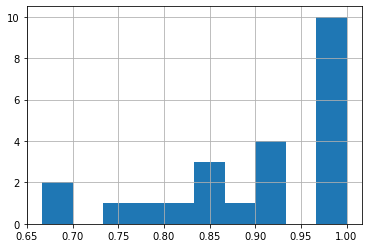

In [36]:
pd.DataFrame({'Guess':labs,
              'Win':(np.array(labs)==np.array(testlabs))*1}).assign(dummy=1).groupby('Guess').agg('sum').reset_index().\
    assign(WinRate=lambda x : x.Win/x.dummy)['WinRate'].hist()
print(pd.DataFrame({'Guess':labs,
              'Win':(np.array(labs)==np.array(testlabs))*1}).assign(dummy=1).groupby('Guess').agg('sum').reset_index().\
    assign(WinRate=lambda x : x.Win/x.dummy)['WinRate'].median())